## Assignment: Regression, Classification, and Neural Networks

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import expit as sigma
import pickle

import time
from IPython.display import display
from ipywidgets import FloatProgress

In [2]:
def concat1(x):
    return np.append(np.ones([1, x.shape[1]]), x, axis=0)

def threshold(x): 
    return ((np.sign(x) + 1) / 2).astype(int) 

def mse(predictions, targets):
    return (1 / 2 * (predictions - targets) ** 2).mean()

def gaussian(x, mu, sigma):
    #return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))
    return np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))

In [6]:
def Plot(X, Y, Z, dataSet, labels):
    plt.contour(X, Y, Z)

    for d in range(dataSet.shape[1]): 
        plt.scatter(dataSet[0][d], dataSet[1][d], color = 'red' if labels[0][d] ==1 else 'blue' )

    plt.xlabel('$x_1$');
    plt.ylabel('$x_2$');

    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    fig = plt.figure()
    ax = fig.gca(projection='3d')  
    surf = ax.plot_surface(X, Y, Z, cmap=cm.jet, linewidth=0, cstride=1, rstride=1)

    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("$z$");
    ax.view_init(azim=60)

# 1. The Perceptron (Classification)

In [4]:
# Reading Data
with open('perceptron-data.pkl', 'rb') as f:
    perceptron_data = pickle.load(f, encoding='bytes')
    
labels = perceptron_data[b'labels']
dataSet = perceptron_data[b'vectors']
#dataSet_augmented = np.append(np.ones([1, dataSet.shape[1]]), dataSet, axis=0)

In [5]:
class Perceptron():
    def __init__(self):
        self.w = []
        
    def learning(self, dataPoint, target, learningRate):
        output = threshold (np.dot (self.w, dataPoint)) 
        
        for idx in range(len(self.w)):
            self.w[idx] += learningRate * dataPoint[idx] * (target - output)

        return self.w

    def accuracy(self, dataSet, labels):
        predictedLabels = threshold (np.dot (self.w, dataSet)) 

        return np.sum(abs(predictedLabels - labels.T)) / len(labels) * 100

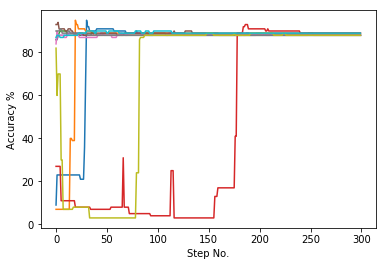

In [8]:
learningRate = 0.1
step = 300
run = 10
inputDimension = concat1(dataSet).shape[0] 
inputNo = dataSet.shape[1]

percept = Perceptron()

accur = np.zeros([run, step])

for i in range(run):
    percept.w = np.array([random.uniform(-1, 1) for ww in range(inputDimension)])
    
    for s in range(step):
        r = random.randint(0, inputNo - 1)
        dataPoint = concat1(dataSet)[:, r]
        target = labels[r]
        
        w = percept.learning(dataPoint, target, learningRate)

        accur[i][s] = percept.accuracy(concat1(dataSet), labels)
            
    plt.plot(accur[i]) 
       
plt.xlabel('Step No.')
plt.ylabel('Accuracy %');


# 2. Regression 

In [9]:
# Reading Data
with open('regression-data.pkl', 'rb') as f:
    regression_data = pickle.load(f, encoding='bytes')
    
trainx = regression_data[b'trainx'].T
trainy = regression_data[b'trainy'].T

testx = regression_data[b'testx'].T
testy = regression_data[b'testy'].T

In [10]:
class Regression():
    def __init__(self, M):    # M = order of model
        self.M = M  #number of feature or function
        self.sigma = []  # Gaussian basis function parameter 
        self.W = []
    
    def basisFunction(self, sigma, muRange):
        self.sigma = sigma
        #self.mu = np.array([random.uniform(muRange[0], muRange[1]) for m in range(self.M)])
        self.mu = np.linspace(muRange[0], muRange[1], 20)
 
        x = np.arange(muRange[0], muRange[1], 0.001)
        for m in self.mu:
            plt.plot(x, gaussian(x, m, sigma))
       
        plt.xlabel('x')
        plt.ylabel('Basis Function')
        plt.figure()
    
    def featureExtraction(self, xData):
        F = []   #feature matrix
        for x in xData:
            for m in range(self.M):
                F.append(gaussian(x, self.mu[m], self.sigma))
        
        F = np.reshape(np.array(F), (len(xData), self.M)) # feature matrix row: data & Column: feature
        
        return F
    
    def train(self, xTrain, tTrain, Lambda):
        F = self.featureExtraction(xTrain)
        F_pinv = np.dot(np.linalg.inv(np.dot(F.T, F) + Lambda * np.eye(self.M)), F.T)
        self.W = np.dot(F_pinv, tTrain)
        
        return self.W
    
    def error(self, xData, tData):
        output = self.model(xData)
        error = mse(output, tData)
        
        return error
    
    def model(self, xData):
        F = self.featureExtraction(xData)
        output = np.dot(F, self.W)
        
        return output

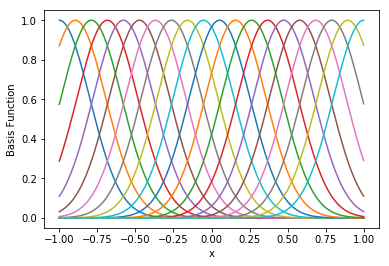

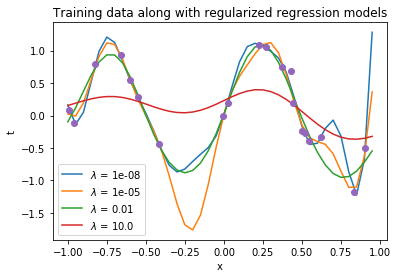

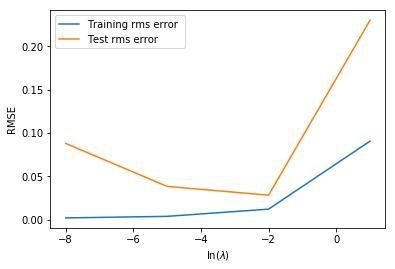

In [11]:
regres = Regression(20)
regres.basisFunction(sigma = 0.2, muRange = [-1, 1])

Lambda = [1e-8, 1e-5, 1e-2, 1e1]
error = []

for l in Lambda:
    W = regres.train(trainx, trainy, l)
    
    error.append([regres.error(trainx, trainy), regres.error(testx, testy)]) 
    
    x = np.arange(-1, 1, 0.05) 
    y = regres.model(x)
    plt.plot(x, y, label = '$\lambda$ = ' + str(l))

plt.plot(trainx, trainy, 'o')
plt.title('Training data along with regularized regression models')
plt.xlabel('x')
plt.ylabel('t')
plt.legend();

plt.figure()
error = np.array(error)

myLabel = 'Training rms error '
for ii in range(2): 
    plt.plot(np.log10(Lambda), error[:,ii], label = myLabel)
    myLabel = 'Test rms error'
    
plt.xlabel('ln($\lambda$)')
plt.ylabel('RMSE')
plt.legend();

# 3. Backpropagation 

In [3]:
# Reading Data
with open('backprop-data.pkl', 'rb') as f:
    backprop_data = pickle.load(f, encoding='bytes')
    
labels = backprop_data[b'labels'].T
dataTrain = backprop_data[b'vectors']
# dataSet_augmented = np.append(np.ones([1, dataSet.shape[1]]), dataSet, axis=0)

In [7]:
class NeuralNetwork():

    def __init__(self, n_input, n_hidden, n_output):
        
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        # W is  n_hidden x (n_input + 1) weight matrix between input & hidden layer
        self.W = []
        for r in range(n_hidden):
            self.W.append([random.uniform(-1, 1) for c in range(n_input + 1)])
        self.W = np.array(self.W)

        # M is  n_output x (n_hidden + 1) weight matrix between input & hidden layer
        self.M = []
        for r in range(n_output):
            self.M.append([random.uniform(-1, 1) for c in range(n_hidden + 1)])
        self.M = np.array(self.M)
        
    def feedforward(self, dataSet):
        self.a = np.dot(self.W, concat1(dataSet))
        self.y = np.tanh(self.a)

        self.b = np.dot(self.M, concat1(self.y))
        self.z = sigma(self.b)
    
        return self.z
    
    def sto_grad(self, dataSet, labels, learningRate):
        
        r = random.randint(0, dataSet.shape[1] - 1)
        dataPoint = dataSet[:, r]
        dataPoint = dataPoint.reshape(len(dataPoint), 1) #list --> Column vector 
        
        targets = labels[:, r]
        targets = targets.reshape(len(targets), 1)       #list --> Column vector 
        
        self.feedforward(dataPoint)
        
        
        sigma_prime = self.z * (1 - self.z)
        gradE_b = (targets - self.z) * sigma_prime
        
        M_delta = gradE_b @ concat1(self.y).T
        
        self.M += learningRate * M_delta
        
        tanh_prime = 1 / (np.cosh(self.a) ** 2)
        gradE_a = tanh_prime * (self.M[:, 1:].T) @ gradE_b
        W_delta = np.dot(gradE_a, concat1(dataPoint).T)
        
        self.W += learningRate * W_delta        


#### Untrained Network

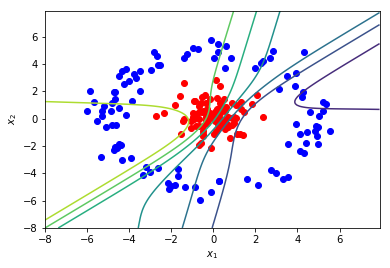

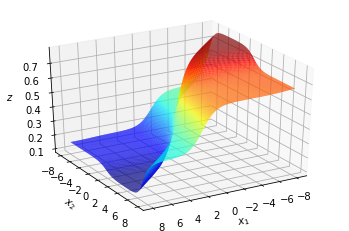

In [8]:
n_input = dataTrain.shape[0]  # number of input node(s) (input dimension)
n_hidden = 5 # number of hidden layer nodes
n_output = 1  #number of output layer node(s)

net = NeuralNetwork(n_input, n_hidden, n_output)

# Befor taining plots
x1 = np.arange(-8, 8, 0.1)
x2 = np.arange(-8, 8, 0.1)
X1, X2 = np.meshgrid(x1, x2)

x1 = X1.flatten()
x2 = X2.flatten()
dataSet = np.array([x1, x2])

z = net.feedforward(dataSet).flatten()

Z = z.reshape(X1.shape)

Plot(X1, X2, Z, dataTrain, labels)

#### Trained Network

FloatProgress(value=0.0, max=1000.0)

Total time: 0.20828914642333984


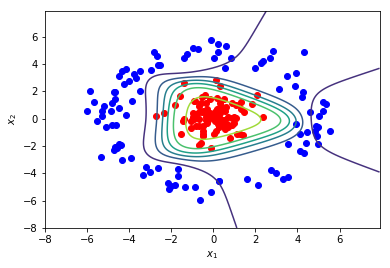

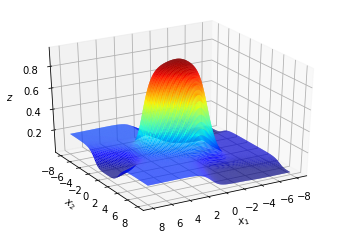

In [10]:
learningRate = 0.3
iteration = 1000

fp = FloatProgress(min = 0, max = iteration)
start_time = time.time()
display(fp)

for ii in range(iteration):
    net.sto_grad(dataTrain, labels, learningRate)
    
    if iteration % 10 == 0:
        fp.value += 10

end_time = time.time()
print('Total time: '+str(end_time-start_time))        

#Plot after training
z = net.feedforward(dataSet).flatten()

Z = z.reshape(X1.shape)

Plot(X1, X2, Z, dataTrain, labels)


#### Bonus Part

The other approach to solve gradient descent problem, rather than backprop is known as finite-difference approximation. In this method the grdiant of Loss function w.r.t to a weigh element $\theta_i$ is numerically approximated as; 

$$
\begin{align}
\frac{\partial E}{\partial \theta_i} &\approx \frac{E(\theta_i + \delta \theta_i) - E(\theta_i - \delta \theta_i)}{2\delta \theta_i}
\end{align}
$$

where $\delta \theta_i$ is a small change in weight value. Then the weight will be updated according to gradient discent formula; 

$$
\begin{align}
\theta_i^{new} &= \theta_i^{old} - \lambda\frac{\partial E}{\partial \theta_i}
\end{align}
$$

This approach is slower than backprop. If the computation time of back propagation is $O(\frac{1}{n})$, the finitie-difference approximation run time is in the order of $O(\frac{1}{\sqrt n})$.
For example in the problem above total time of iteration for backprop lasts 0.14 sec on this machine. The computation time for the mothod based on approximating the gradient numerically would be 0.37 sec.   